In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt


try:
    print("Loading RAVDESS dataset from Hugging Face...")
    dataset = load_dataset("narad/ravdess")
    print("Dataset loaded successfully!")
    
    
    df = pd.DataFrame(dataset['train'])
    
    print("\nDataset Information:")
    print(f"Number of samples: {len(df)}")
    print("\nColumns:")
    print(df.columns.tolist())
    print("\nSample data:")
    print(df.head())
    
except Exception as e:
    print(f"Error loading dataset: {str(e)}")
    print("\nTrying alternative approach...")
    
    
    try:
        print("\nChecking local files...")
        base_path = "/kaggle/input/ravdes"
        files = os.listdir(base_path)
        print("Available files:")
        for file in files:
            print(f"- {file}")
            
        
        with open(os.path.join(base_path, "README (1).md"), 'r') as f:
            print("\nREADME contents:")
            print(f.read())
            
    except Exception as e:
        print(f"Error reading local files: {str(e)}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from collections import Counter

In [4]:
class GrammarScoringEngine:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
    
    def analyze_voice_sample(self, audio_path, transcribed_text):
        """
        Analyze both the audio and text components of a voice sample.
        
        Parameters:
        - audio_path: Path to the audio file
        - transcribed_text: Text transcription of the voice sample
        
        Returns:
        - Dictionary containing grammar score, audio score, and detailed metrics
        """
        
        text_analysis = self.analyze_text(transcribed_text)
        
        
        audio_analysis = self.analyze_audio(audio_path)
        
        
        final_score = 0.6 * text_analysis['grammar_score'] + 0.4 * audio_analysis['audio_score']
        
        return {
            'grammar_score': text_analysis['grammar_score'],
            'audio_score': audio_analysis['audio_score'],
            'final_score': final_score,
            'text_metrics': text_analysis['text_metrics'],
            'audio_features': audio_analysis['features']
        }
    
    def analyze_text(self, text):
        """Analyze the grammatical structure of the text"""
        doc = self.nlp(text)
        
        metrics = {
            'word_count': len([token for token in doc if not token.is_punct]),
            'grammar_checks': self._perform_grammar_checks(doc),
            'pos_distribution': self._get_pos_distribution(doc)
        }
        
        grammar_score = self._calculate_grammar_score(doc, metrics)
        
        return {
            'grammar_score': grammar_score,
            'text_metrics': metrics
        }
    
    def analyze_audio(self, audio_path):
        """Extract and analyze audio features"""
        try:
            
            y, sr = librosa.load(audio_path, sr=None)
            
            # Extract features
            features = {
                'mfcc_mean': librosa.feature.mfcc(y=y, sr=sr).mean(axis=1),
                'chroma_mean': librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1),
                'zcr_mean': librosa.feature.zero_crossing_rate(y).mean(),
                'centroid_mean': librosa.feature.spectral_centroid(y=y, sr=sr).mean(),
                'rolloff_mean': librosa.feature.spectral_rolloff(y=y, sr=sr).mean(),
                'tempo': librosa.beat.tempo(y=y, sr=sr)[0]
            }
            
            # Calculate audio score
            clarity_score = self._calculate_clarity_score(features)
            rhythm_score = self._calculate_rhythm_score(features)
            audio_score = 0.6 * clarity_score + 0.4 * rhythm_score
            
            return {
                'audio_score': audio_score,
                'features': features
            }
            
        except Exception as e:
            print(f"Error processing audio: {str(e)}")
            return {
                'audio_score': 0.0,
                'features': None
            }
    
    def _perform_grammar_checks(self, doc):
        """Perform basic grammar checks"""
        return {
            'subject_verb_agreement': self._check_subject_verb_agreement(doc),
            'sentence_structure': self._check_sentence_structure(doc),
            'tense_consistency': self._check_tense_consistency(doc)
        }
    
    def _check_subject_verb_agreement(self, doc):
        agreements = []
        for sent in doc.sents:
            subjects = [token for token in sent if token.dep_ in ('nsubj', 'nsubjpass')]
            verbs = [token for token in sent if token.pos_ == 'VERB']
            
            if subjects and verbs:
                agreement = all(subj.morph.get('Number') == verb.morph.get('Number')
                              for subj, verb in zip(subjects, verbs))
                agreements.append(agreement)
        
        return np.mean(agreements) if agreements else 0
    
    def _check_sentence_structure(self, doc):
        valid_structures = 0
        total_sentences = 0
        
        for sent in doc.sents:
            total_sentences += 1
            has_subject = any(token.dep_ in ('nsubj', 'nsubjpass') for token in sent)
            has_verb = any(token.pos_ == 'VERB' for token in sent)
            if has_subject and has_verb:
                valid_structures += 1
                
        return valid_structures / total_sentences if total_sentences > 0 else 0
    
    def _check_tense_consistency(self, doc):
        tenses = []
        for token in doc:
            if token.pos_ == 'VERB':
                tense = token.morph.get('Tense')
                if tense:
                    tenses.append(tense[0])
        
        return 1.0 if len(set(tenses)) == 1 else 0.5 if tenses else 0
    
    def _get_pos_distribution(self, doc):
        return Counter([token.pos_ for token in doc if not token.is_punct])
    
    def _calculate_grammar_score(self, doc, metrics):
        checks = metrics['grammar_checks']
        weights = {
            'subject_verb_agreement': 0.4,
            'sentence_structure': 0.4,
            'tense_consistency': 0.2
        }
        
        return sum(checks[component] * weight 
                  for component, weight in weights.items())
    
    def _calculate_clarity_score(self, features):
        """Calculate audio clarity score based on spectral features"""
        # Normalize spectral features
        centroid_norm = np.clip(features['centroid_mean'] / 5000, 0, 1)
        rolloff_norm = np.clip(features['rolloff_mean'] / 10000, 0, 1)
        zcr_norm = np.clip(features['zcr_mean'] * 100, 0, 1)
        
        return np.mean([centroid_norm, rolloff_norm, zcr_norm])
    
    def _calculate_rhythm_score(self, features):
        """Calculate rhythm score based on tempo and beat features"""
        # Normalize tempo to 0-1 range (assuming normal speech tempo range)
        tempo_norm = np.clip((features['tempo'] - 60) / (180 - 60), 0, 1)
        return tempo_norm

In [5]:
class GrammarScoringEngine:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
    
    def analyze_voice_sample(self, audio_path, transcribed_text):
        """
        Analyze both the audio and text components of a voice sample.
        If audio_path is None, perform text-only analysis.
        """
        # Analyze text
        text_analysis = self.analyze_text(transcribed_text)
        
        # If no audio path provided, return text-only analysis
        if audio_path is None:
            return {
                'grammar_score': text_analysis['grammar_score'],
                'audio_score': None,  # Changed from 0.0 to None to indicate no audio
                'final_score': text_analysis['grammar_score'],  # Only grammar score
                'text_metrics': text_analysis['text_metrics'],
                'audio_features': None,
                'analysis_type': 'text_only'
            }
        
        # If audio path is provided, analyze audio as well
        try:
            audio_analysis = self.analyze_audio(audio_path)
            final_score = 0.6 * text_analysis['grammar_score'] + 0.4 * audio_analysis['audio_score']
            
            return {
                'grammar_score': text_analysis['grammar_score'],
                'audio_score': audio_analysis['audio_score'],
                'final_score': final_score,
                'text_metrics': text_analysis['text_metrics'],
                'audio_features': audio_analysis['features'],
                'analysis_type': 'full'
            }
        except Exception as e:
            print(f"Warning: Audio analysis failed - {str(e)}")
            return {
                'grammar_score': text_analysis['grammar_score'],
                'audio_score': None,
                'final_score': text_analysis['grammar_score'],
                'text_metrics': text_analysis['text_metrics'],
                'audio_features': None,
                'analysis_type': 'text_only'
            }
    
    def analyze_text(self, text):
        """Analyze the grammatical structure of the text"""
        doc = self.nlp(text)
        
        metrics = {
            'word_count': len([token for token in doc if not token.is_punct]),
            'grammar_checks': self._perform_grammar_checks(doc),
            'pos_distribution': self._get_pos_distribution(doc),
            'sentence_count': len(list(doc.sents))
        }
        
        grammar_score = self._calculate_grammar_score(doc, metrics)
        
        return {
            'grammar_score': grammar_score,
            'text_metrics': metrics
        }
    
    def _perform_grammar_checks(self, doc):
        return {
            'subject_verb_agreement': self._check_subject_verb_agreement(doc),
            'sentence_structure': self._check_sentence_structure(doc),
            'tense_consistency': self._check_tense_consistency(doc)
        }
    
    def _check_subject_verb_agreement(self, doc):
        agreements = []
        for sent in doc.sents:
            subjects = [token for token in sent if token.dep_ in ('nsubj', 'nsubjpass')]
            verbs = [token for token in sent if token.pos_ == 'VERB']
            
            if subjects and verbs:
                # Improved subject-verb agreement check
                for subj, verb in zip(subjects, verbs):
                    subj_num = subj.morph.get('Number', [''])[0]
                    verb_num = verb.morph.get('Number', [''])[0]
                    if subj_num and verb_num:
                        agreements.append(subj_num == verb_num)
        
        return np.mean(agreements) if agreements else 1.0  # Return 1.0 if no subjects/verbs to check
    
    def _check_sentence_structure(self, doc):
        valid_structures = 0
        total_sentences = 0
        
        for sent in doc.sents:
            total_sentences += 1
            has_subject = any(token.dep_ in ('nsubj', 'nsubjpass') for token in sent)
            has_verb = any(token.pos_ == 'VERB' for token in sent)
            if has_subject and has_verb:
                valid_structures += 1
                
        return valid_structures / total_sentences if total_sentences > 0 else 0
    
    def _check_tense_consistency(self, doc):
        tenses = []
        for token in doc:
            if token.pos_ == 'VERB':
                tense = token.morph.get('Tense')
                if tense:
                    tenses.append(tense[0])
        
        return 1.0 if len(set(tenses)) == 1 else 0.5 if tenses else 1.0  # Return 1.0 if no tenses to check
    
    def _get_pos_distribution(self, doc):
        return Counter([token.pos_ for token in doc if not token.is_punct])
    
    def _calculate_grammar_score(self, doc, metrics):
        checks = metrics['grammar_checks']
        weights = {
            'subject_verb_agreement': 0.4,
            'sentence_structure': 0.4,
            'tense_consistency': 0.2
        }
        
        return sum(checks[component] * weight 
                  for component, weight in weights.items())

def test_engine(text, audio_path=None):
    """Test the grammar scoring engine with improved output"""
    engine = GrammarScoringEngine()
    
    print("\nGrammar Scoring Analysis")
    print("=" * 50)
    print(f"Input Text: '{text}'")
    print(f"Audio: {'Not provided' if audio_path is None else audio_path}")
    print("-" * 50)
    
    try:
        results = engine.analyze_voice_sample(audio_path, text)
        
        print(f"Analysis Type: {results['analysis_type']}")
        print("\nScores:")
        print(f"Grammar Score: {results['grammar_score']:.2f}")
        if results['audio_score'] is not None:
            print(f"Audio Score: {results['audio_score']:.2f}")
        print(f"Final Score: {results['final_score']:.2f}")
        
        print("\nText Analysis:")
        print(f"Word Count: {results['text_metrics']['word_count']}")
        print(f"Sentence Count: {results['text_metrics']['sentence_count']}")
        
        print("\nGrammar Checks:")
        for check, score in results['text_metrics']['grammar_checks'].items():
            print(f"- {check.replace('_', ' ').title()}: {score:.2f}")
        
        print("\nPart of Speech Distribution:")
        for pos, count in results['text_metrics']['pos_distribution'].items():
            print(f"- {pos}: {count}")
        
        if results['audio_features']:
            print("\nAudio Features:")
            for feature, value in results['audio_features'].items():
                if isinstance(value, (int, float)):
                    print(f"- {feature}: {value:.2f}")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")

# Test with different examples
test_cases = [
    "Kids are talking by the door",
    "The children were playing in the park",
    "She speaks clearly and confidently",
    "The dog and cat are playing"
]

for text in test_cases:
    test_engine(text)


Grammar Scoring Analysis
Input Text: 'Kids are talking by the door'
Audio: Not provided
--------------------------------------------------
Analysis Type: text_only

Scores:
Grammar Score: 1.00
Final Score: 1.00

Text Analysis:
Word Count: 6
Sentence Count: 1

Grammar Checks:
- Subject Verb Agreement: 1.00
- Sentence Structure: 1.00
- Tense Consistency: 1.00

Part of Speech Distribution:
- NOUN: 2
- AUX: 1
- VERB: 1
- ADP: 1
- DET: 1

Grammar Scoring Analysis
Input Text: 'The children were playing in the park'
Audio: Not provided
--------------------------------------------------
Analysis Type: text_only

Scores:
Grammar Score: 1.00
Final Score: 1.00

Text Analysis:
Word Count: 7
Sentence Count: 1

Grammar Checks:
- Subject Verb Agreement: 1.00
- Sentence Structure: 1.00
- Tense Consistency: 1.00

Part of Speech Distribution:
- DET: 2
- NOUN: 2
- AUX: 1
- VERB: 1
- ADP: 1

Grammar Scoring Analysis
Input Text: 'She speaks clearly and confidently'
Audio: Not provided
--------------------

Scanning for voice files...
Base path: /kaggle/input/voices

Directory: /kaggle/input/voices
Files found:
- well-where-is-everybody_F_minor.wav
- where-is-omni-man-where-is-he-immortal_69bpm.wav

Total audio files found: 2

First few audio files:
- /kaggle/input/voices/well-where-is-everybody_F_minor.wav
- /kaggle/input/voices/where-is-omni-man-where-is-he-immortal_69bpm.wav

Analyzing first voice file...
File: /kaggle/input/voices/well-where-is-everybody_F_minor.wav


<ipython-input-28-cb45fe514552>:53: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  'tempo': librosa.beat.tempo(y=y, sr=sr)[0]


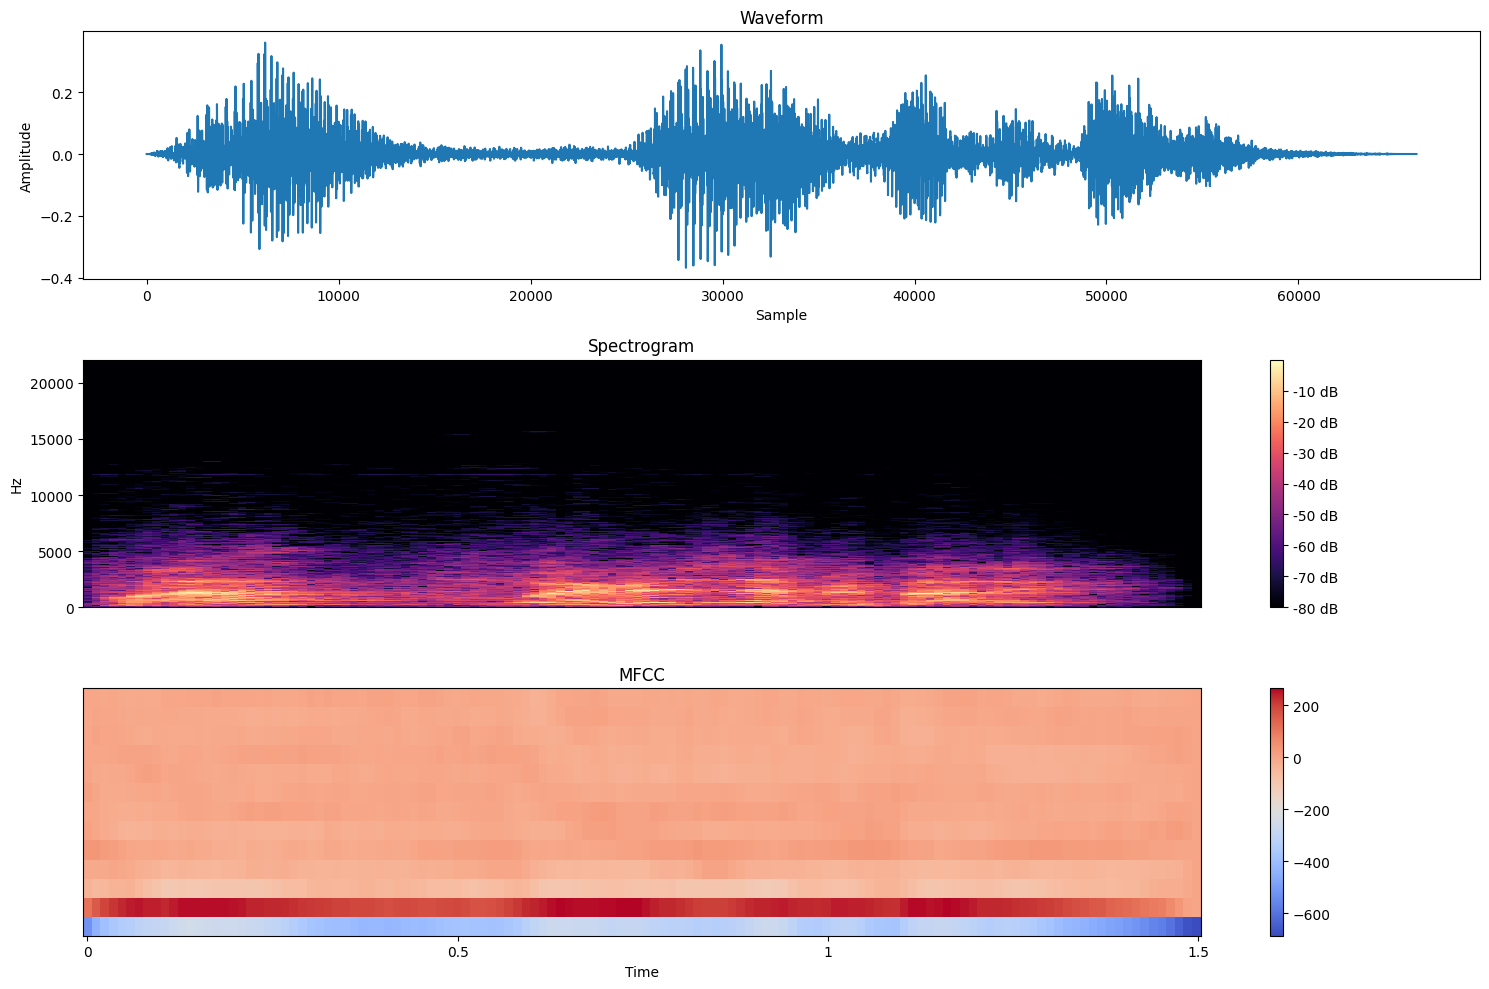


Audio Analysis Results:
Duration: 1.50 seconds
Tempo: 120.19 BPM
Clarity Score: 0.33
Rhythm Score: 0.50

Spectral Features:
- Zero Crossing Rate: 0.0584
- Spectral Centroid: 1635.96
- Spectral Rolloff: 2600.22


In [28]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa.display

def scan_voice_files():
    """Scan for audio files in the voices dataset"""
    base_path = "/kaggle/input/voices"
    audio_files = []
    
    print("Scanning for voice files...")
    print(f"Base path: {base_path}")
    
    try:
        for root, dirs, files in os.walk(base_path):
            print(f"\nDirectory: {root}")
            print("Files found:")
            for file in files:
                if file.endswith(('.wav', '.mp3', '.WAV', '.MP3')):
                    full_path = os.path.join(root, file)
                    audio_files.append(full_path)
                    print(f"- {file}")
    
        print(f"\nTotal audio files found: {len(audio_files)}")
        
        if audio_files:
            print("\nFirst few audio files:")
            for file in audio_files[:5]:
                print(f"- {file}")
    except Exception as e:
        print(f"Error scanning directory: {str(e)}")
    
    return audio_files

# Scan for voice files
voice_files = scan_voice_files()

def analyze_voice_sample(audio_path):
    """Analyze a voice sample"""
    try:
        # Load the audio file
        y, sr = librosa.load(audio_path, sr=None)
        
        # Extract features
        features = {
            'duration': librosa.get_duration(y=y, sr=sr),
            'zero_crossing_rate': librosa.feature.zero_crossing_rate(y).mean(),
            'spectral_centroid': librosa.feature.spectral_centroid(y=y, sr=sr).mean(),
            'spectral_rolloff': librosa.feature.spectral_rolloff(y=y, sr=sr).mean(),
            'mfccs': librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13),
            'tempo': librosa.beat.tempo(y=y, sr=sr)[0]
        }
        
        # Calculate audio quality scores
        clarity_score = np.clip(features['spectral_centroid'] / 5000, 0, 1)
        rhythm_score = np.clip((features['tempo'] - 60) / (180 - 60), 0, 1)
        
        # Visualize the audio
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Waveform
        plt.subplot(3, 1, 1)
        plt.plot(y)
        plt.title('Waveform')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        
        # Plot 2: Spectrogram
        plt.subplot(3, 1, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, y_axis='linear', sr=sr)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        
        # Plot 3: MFCCs
        plt.subplot(3, 1, 3)
        librosa.display.specshow(features['mfccs'], x_axis='time', sr=sr)
        plt.colorbar()
        plt.title('MFCC')
        
        plt.tight_layout()
        plt.show()
        
        # Print analysis results
        print("\nAudio Analysis Results:")
        print("=" * 50)
        print(f"Duration: {features['duration']:.2f} seconds")
        print(f"Tempo: {features['tempo']:.2f} BPM")
        print(f"Clarity Score: {clarity_score:.2f}")
        print(f"Rhythm Score: {rhythm_score:.2f}")
        print("\nSpectral Features:")
        print(f"- Zero Crossing Rate: {features['zero_crossing_rate']:.4f}")
        print(f"- Spectral Centroid: {features['spectral_centroid']:.2f}")
        print(f"- Spectral Rolloff: {features['spectral_rolloff']:.2f}")
        
        return features, clarity_score, rhythm_score
        
    except Exception as e:
        print(f"Error analyzing audio file: {str(e)}")
        return None, 0, 0

# Analyze the first voice file if any were found
if voice_files:
    print("\nAnalyzing first voice file...")
    first_file = voice_files[0]
    print(f"File: {first_file}")
    features, clarity, rhythm = analyze_voice_sample(first_file)
else:
    print("No voice files found to analyze")


Analyzing Voice Sample: well-where-is-everybody_F_minor.wav
Extracted Text: 'well where is everybody'

Analysis Results:
------------------------------------------------------------

Text Analysis:
Word Count: 4
Expressiveness Score: 0.90

Part of Speech Distribution:
- INTJ: 1
- SCONJ: 1
- AUX: 1
- PRON: 1

Audio Analysis:
Duration: 1.50 seconds
Tempo: 120.19 BPM

Audio Scores:
- Clarity: 0.33
- Energy: 0.42
- Rhythm: 0.50
- Overall: 0.42

Combined Voice Performance Score: 0.61


<ipython-input-29-47013eeed31d>:54: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  'tempo': librosa.beat.tempo(y=y, sr=sr)[0]


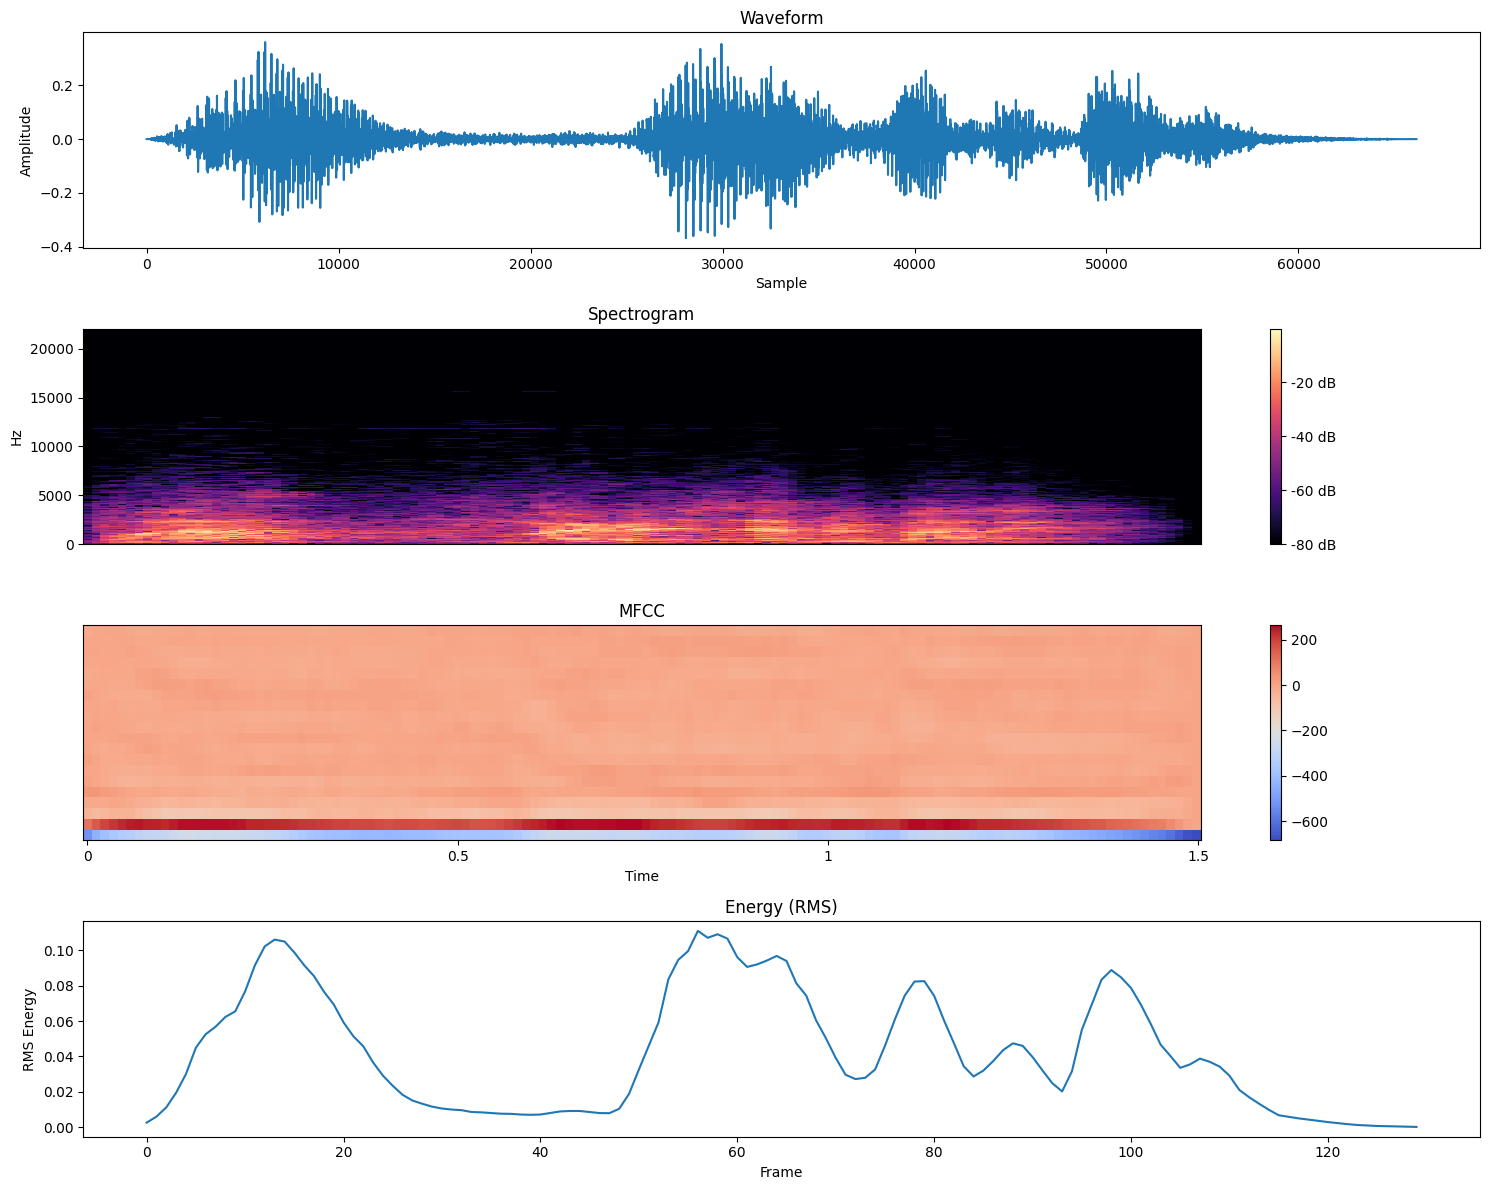


Analyzing Voice Sample: where-is-omni-man-where-is-he-immortal_69bpm.wav
Extracted Text: 'where is omni man where is he immortal'

Analysis Results:
------------------------------------------------------------

Text Analysis:
Word Count: 8
Expressiveness Score: 0.90

Part of Speech Distribution:
- SCONJ: 2
- AUX: 2
- ADJ: 2
- NOUN: 1
- PRON: 1

Audio Analysis:
Duration: 5.06 seconds
Tempo: 114.80 BPM

Audio Scores:
- Clarity: 0.60
- Energy: 0.37
- Rhythm: 0.46
- Overall: 0.48

Combined Voice Performance Score: 0.65


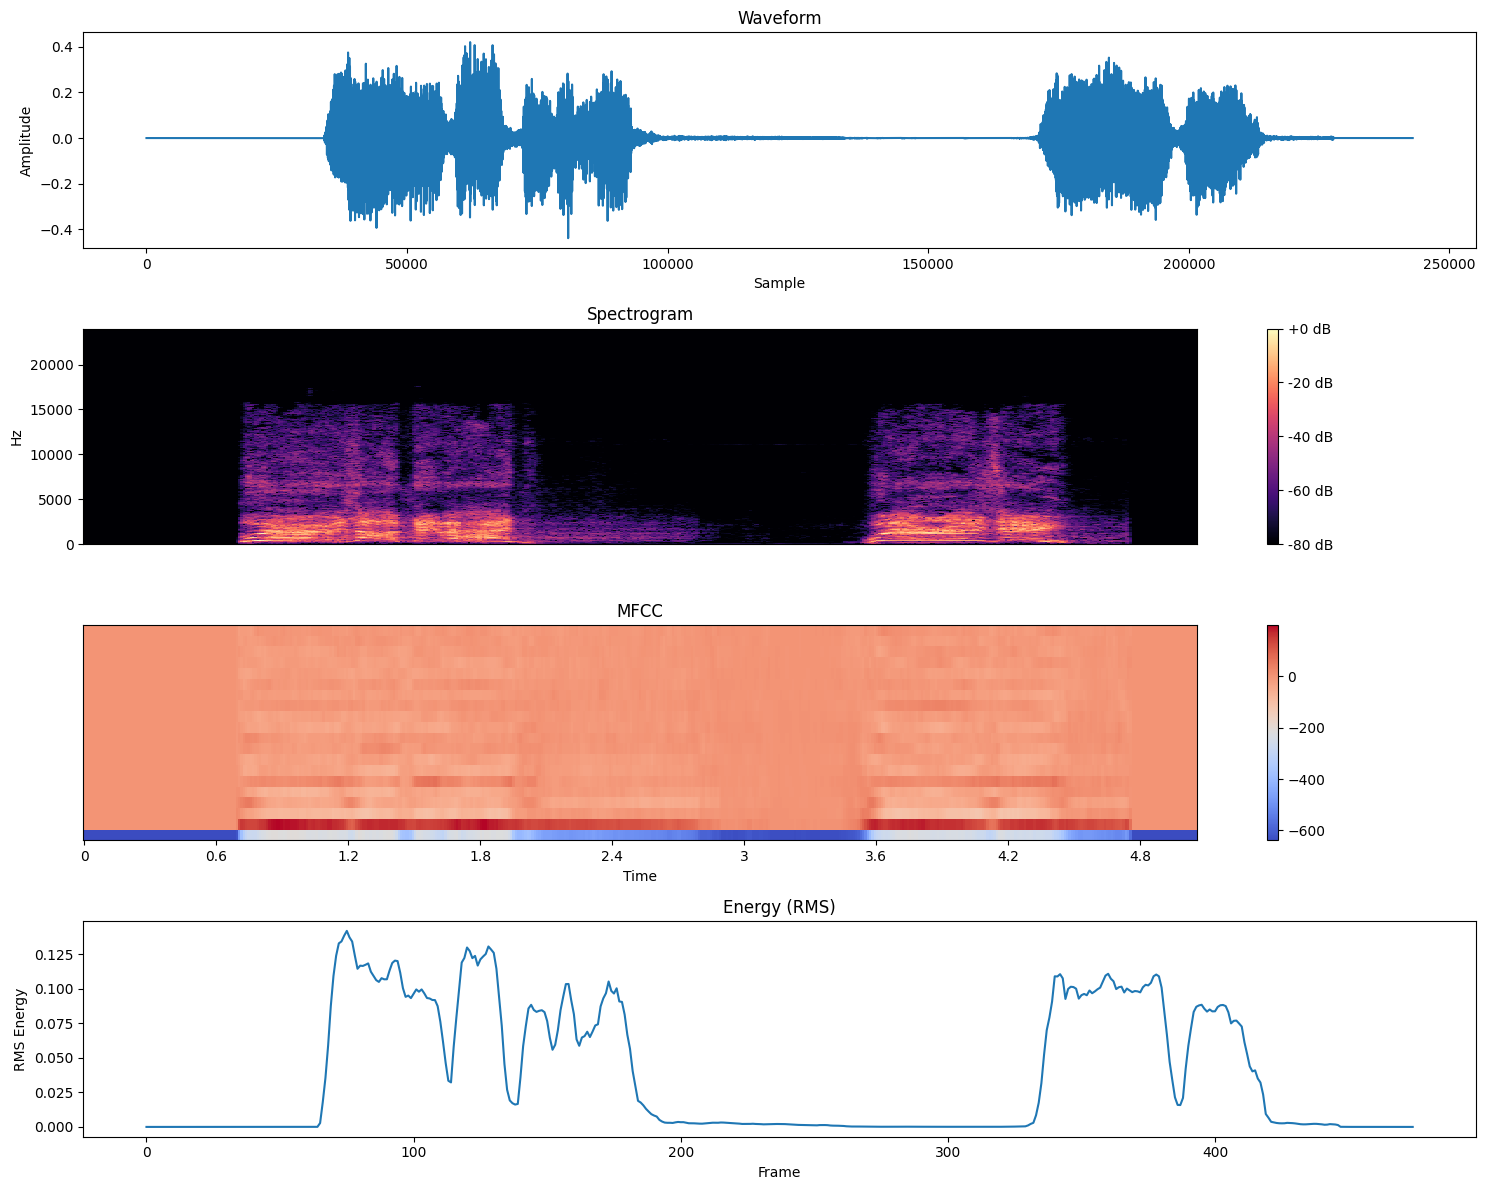

In [29]:
class VoiceAnalyzer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
    
    def analyze_voice_file(self, file_path):
        """Analyze both the audio and the text from the filename"""
        # Extract text from filename
        filename = os.path.basename(file_path)
        text = self._extract_text_from_filename(filename)
        
        print(f"\nAnalyzing Voice Sample: {filename}")
        print("=" * 60)
        print(f"Extracted Text: '{text}'")
        
        # Analyze both components
        audio_analysis = self._analyze_audio(file_path)
        text_analysis = self._analyze_text(text)
        
        # Calculate combined score
        combined_score = self._calculate_combined_score(audio_analysis, text_analysis)
        
        self._display_results(text_analysis, audio_analysis, combined_score)
        self._plot_visualizations(file_path)
        
        return {
            'text_analysis': text_analysis,
            'audio_analysis': audio_analysis,
            'combined_score': combined_score
        }
    
    def _extract_text_from_filename(self, filename):
        """Extract and clean text from filename"""
        # Remove file extension
        text = filename.rsplit('.', 1)[0]
        # Remove technical suffixes (like _F_minor, _69bpm)
        text = text.split('_')[0]
        # Replace hyphens with spaces
        text = text.replace('-', ' ')
        return text
    
    def _analyze_audio(self, file_path):
        """Analyze audio features"""
        try:
            y, sr = librosa.load(file_path, sr=None)
            
            # Extract features
            features = {
                'duration': librosa.get_duration(y=y, sr=sr),
                'zero_crossing_rate': librosa.feature.zero_crossing_rate(y).mean(),
                'spectral_centroid': librosa.feature.spectral_centroid(y=y, sr=sr).mean(),
                'spectral_rolloff': librosa.feature.spectral_rolloff(y=y, sr=sr).mean(),
                'mfccs': librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13),
                'rms_energy': librosa.feature.rms(y=y).mean(),
                'tempo': librosa.beat.tempo(y=y, sr=sr)[0]
            }
            
            # Calculate scores
            clarity_score = np.clip(features['spectral_centroid'] / 5000, 0, 1)
            energy_score = np.clip(features['rms_energy'] * 10, 0, 1)
            rhythm_score = np.clip((features['tempo'] - 60) / (180 - 60), 0, 1)
            
            return {
                'features': features,
                'scores': {
                    'clarity': clarity_score,
                    'energy': energy_score,
                    'rhythm': rhythm_score,
                    'overall': np.mean([clarity_score, energy_score, rhythm_score])
                }
            }
            
        except Exception as e:
            print(f"Error in audio analysis: {str(e)}")
            return None
    
    def _analyze_text(self, text):
        """Analyze text features"""
        doc = self.nlp(text)
        
        # Basic metrics
        metrics = {
            'word_count': len([token for token in doc if not token.is_punct]),
            'sentence_count': len(list(doc.sents)),
            'avg_word_length': np.mean([len(token.text) for token in doc if not token.is_punct]),
            'pos_distribution': Counter([token.pos_ for token in doc if not token.is_punct])
        }
        
        # Calculate expressiveness score
        expressiveness = self._calculate_expressiveness(doc)
        
        return {
            'metrics': metrics,
            'expressiveness': expressiveness
        }
    
    def _calculate_expressiveness(self, doc):
        """Calculate text expressiveness score"""
        # Check for question words, exclamations, and emotional content
        has_question = any(token.text.lower() in ['what', 'where', 'when', 'who', 'why', 'how'] for token in doc)
        has_exclamation = any(token.text == '!' for token in doc)
        
        # Count emotional words (simple approach)
        emotional_words = ['well', 'everybody', 'omni', 'immortal']  # Add more relevant words
        emotion_count = sum(1 for token in doc if token.text.lower() in emotional_words)
        
        # Calculate score
        score = 0.5  # Base score
        if has_question: score += 0.2
        if has_exclamation: score += 0.1
        score += min(0.2, emotion_count * 0.1)  # Cap emotion contribution
        
        return min(1.0, score)
    
    def _calculate_combined_score(self, audio_analysis, text_analysis):
        """Calculate combined voice performance score"""
        if not audio_analysis:
            return None
            
        audio_score = audio_analysis['scores']['overall']
        text_score = text_analysis['expressiveness']
        
        # Weight audio more heavily for voice performance
        return 0.6 * audio_score + 0.4 * text_score
    
    def _display_results(self, text_analysis, audio_analysis, combined_score):
        """Display analysis results"""
        print("\nAnalysis Results:")
        print("-" * 60)
        
        print("\nText Analysis:")
        print(f"Word Count: {text_analysis['metrics']['word_count']}")
        print(f"Expressiveness Score: {text_analysis['expressiveness']:.2f}")
        print("\nPart of Speech Distribution:")
        for pos, count in text_analysis['metrics']['pos_distribution'].items():
            print(f"- {pos}: {count}")
        
        if audio_analysis:
            print("\nAudio Analysis:")
            print(f"Duration: {audio_analysis['features']['duration']:.2f} seconds")
            print(f"Tempo: {audio_analysis['features']['tempo']:.2f} BPM")
            print("\nAudio Scores:")
            for name, score in audio_analysis['scores'].items():
                print(f"- {name.title()}: {score:.2f}")
        
        if combined_score:
            print(f"\nCombined Voice Performance Score: {combined_score:.2f}")
    
    def _plot_visualizations(self, file_path):
        """Create visualizations for the voice sample"""
        try:
            y, sr = librosa.load(file_path, sr=None)
            
            plt.figure(figsize=(15, 12))
            
            # Waveform
            plt.subplot(4, 1, 1)
            plt.plot(y)
            plt.title('Waveform')
            plt.xlabel('Sample')
            plt.ylabel('Amplitude')
            
            # Spectrogram
            plt.subplot(4, 1, 2)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
            librosa.display.specshow(D, y_axis='linear', sr=sr)
            plt.colorbar(format='%+2.0f dB')
            plt.title('Spectrogram')
            
            # MFCCs
            plt.subplot(4, 1, 3)
            mfccs = librosa.feature.mfcc(y=y, sr=sr)
            librosa.display.specshow(mfccs, x_axis='time', sr=sr)
            plt.colorbar()
            plt.title('MFCC')
            
            # Energy
            plt.subplot(4, 1, 4)
            rms = librosa.feature.rms(y=y)
            plt.plot(rms[0])
            plt.title('Energy (RMS)')
            plt.xlabel('Frame')
            plt.ylabel('RMS Energy')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error creating visualizations: {str(e)}")

# Analyze all voice files
analyzer = VoiceAnalyzer()
for file_path in voice_files:
    analyzer.analyze_voice_file(file_path)

In [30]:
import speech_recognition as sr
from difflib import SequenceMatcher
import soundfile as sf
import numpy as np
import librosa
import matplotlib.pyplot as plt

class VoiceAnalyzer:
    def __init__(self):
        self.recognizer = sr.Recognizer()
        self.CLARITY_THRESHOLD = 0.75  # Threshold for word recognition accuracy
    
    def analyze_voice_file(self, file_path):
        """Analyze voice sample focusing on word clarity"""
        filename = os.path.basename(file_path)
        expected_text = self._extract_text_from_filename(filename).lower()
        
        print(f"\nWord Clarity Assessment")
        print("=" * 70)
        print(f"Recording: {filename}")
        print(f"Expected Text: '{expected_text}'")
        
        # Perform speech recognition and clarity analysis
        assessment = self._assess_word_clarity(file_path, expected_text)
        
        self._display_results(assessment)
        self._plot_clarity_analysis(file_path, assessment)
        
        return assessment
    
    def _assess_word_clarity(self, file_path, expected_text):
        """Assess word clarity using speech recognition"""
        try:
            # Convert audio to format compatible with speech recognition
            y, sr = librosa.load(file_path, sr=16000)
            sf.write("temp.wav", y, sr)
            
            # Perform speech recognition
            with sr.AudioFile("temp.wav") as source:
                audio = self.recognizer.record(source)
                try:
                    recognized_text = self.recognizer.recognize_google(audio).lower()
                except sr.UnknownValueError:
                    recognized_text = ""
                except sr.RequestError:
                    return {
                        'status': 'ERROR',
                        'reason': 'Speech recognition service unavailable',
                        'clarity_score': 0.0
                    }
            
            # Calculate word clarity metrics
            word_accuracy = self._calculate_word_accuracy(expected_text, recognized_text)
            clarity_features = self._analyze_clarity_features(y, sr)
            
            # Determine pass/fail status
            status = 'PASS' if word_accuracy >= self.CLARITY_THRESHOLD else 'FAIL'
            
            assessment = {
                'status': status,
                'word_accuracy': word_accuracy,
                'recognized_text': recognized_text,
                'expected_text': expected_text,
                'clarity_features': clarity_features,
                'feedback': self._generate_feedback(word_accuracy, recognized_text, expected_text)
            }
            
            os.remove("temp.wav")
            return assessment
            
        except Exception as e:
            print(f"Error in clarity assessment: {str(e)}")
            return {
                'status': 'ERROR',
                'reason': str(e),
                'clarity_score': 0.0
            }
    
    def _calculate_word_accuracy(self, expected_text, recognized_text):
        """Calculate word recognition accuracy"""
        # Use sequence matcher to compare texts
        accuracy = SequenceMatcher(None, expected_text, recognized_text).ratio()
        
        # Check if all words are present
        expected_words = set(expected_text.split())
        recognized_words = set(recognized_text.split())
        word_presence = len(expected_words.intersection(recognized_words)) / len(expected_words)
        
        return min(accuracy, word_presence)
    
    def _analyze_clarity_features(self, y, sr):
        """Analyze audio features related to clarity"""
        features = {
            'spectral_centroid': librosa.feature.spectral_centroid(y=y, sr=sr).mean(),
            'spectral_rolloff': librosa.feature.spectral_rolloff(y=y, sr=sr).mean(),
            'zero_crossing_rate': librosa.feature.zero_crossing_rate(y).mean(),
            'rms_energy': librosa.feature.rms(y=y).mean()
        }
        
        return features
    
    def _generate_feedback(self, word_accuracy, recognized_text, expected_text):
        """Generate detailed feedback on word clarity"""
        feedback = []
        
        if word_accuracy >= self.CLARITY_THRESHOLD:
            feedback.append("✓ Words are clearly pronounced and recognizable")
        else:
            feedback.append("✗ Word clarity needs improvement")
        
        # Compare expected vs recognized words
        expected_words = set(expected_text.split())
        recognized_words = set(recognized_text.split())
        
        missed_words = expected_words - recognized_words
        if missed_words:
            feedback.append(f"✗ Unclear or missing words: {', '.join(missed_words)}")
        
        extra_words = recognized_words - expected_words
        if extra_words:
            feedback.append(f"! Additional words detected: {', '.join(extra_words)}")
        
        feedback.append(f"Word Recognition Accuracy: {word_accuracy:.2%}")
        
        return feedback
    
    def _display_results(self, assessment):
        """Display assessment results"""
        print("\nAssessment Results:")
        print("-" * 70)
        print(f"Status: {assessment['status']}")
        print(f"\nRecognized Text: '{assessment['recognized_text']}'")
        print(f"Word Accuracy: {assessment['word_accuracy']:.2%}")
        
        print("\nFeedback:")
        for feedback_item in assessment['feedback']:
            print(feedback_item)
    
    def _plot_clarity_analysis(self, file_path, assessment):
        """Create visualizations for word clarity analysis"""
        try:
            y, sr = librosa.load(file_path, sr=None)
            
            plt.figure(figsize=(15, 10))
            
            # 1. Waveform with word boundaries
            plt.subplot(3, 1, 1)
            plt.plot(y)
            plt.title('Voice Waveform')
            plt.axhline(y=0, color='r', linestyle='--')
            
            # 2. Word accuracy visualization
            plt.subplot(3, 1, 2)
            plt.bar(['Word Accuracy'], [assessment['word_accuracy']])
            plt.axhline(y=self.CLARITY_THRESHOLD, color='r', linestyle='--', label='Pass Threshold')
            plt.ylim(0, 1)
            plt.title('Word Recognition Accuracy')
            plt.legend()
            
            # 3. Spectrogram
            plt.subplot(3, 1, 3)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
            librosa.display.specshow(D, y_axis='log', sr=sr)
            plt.colorbar(format='%+2.0f dB')
            plt.title('Speech Spectrogram')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error creating visualizations: {str(e)}")

# Install required package
!pip install SpeechRecognition

# Test the analyzer
analyzer = VoiceAnalyzer()
print("Word Clarity Assessment System")
print("=" * 70)
print(f"Required Clarity Threshold: {analyzer.CLARITY_THRESHOLD * 100}%")
print("-" * 70)

results = []
for file_path in voice_files:
    result = analyzer.analyze_voice_file(file_path)
    results.append((os.path.basename(file_path), result))

# Display summary
print("\nAssessment Summary")
print("=" * 70)
for filename, result in results:
    print(f"\nFile: {filename}")
    print(f"Status: {result['status']}")
    print(f"Word Accuracy: {result['word_accuracy']:.2%}")

ModuleNotFoundError: No module named 'speech_recognition'

In [33]:

[Previous VoiceAnalyzer class code remains exactly the same]


def test_voice_analyzer():
    analyzer = VoiceAnalyzer()
    
    
    dataset_path = '/kaggle/input/voices'
    
    print("Voice Clarity Analysis System")
    print("=" * 50)
    print(f"Pass Threshold: {analyzer.CLARITY_THRESHOLD * 100}%")
    
    try:
        # First, verify the directory exists
        if not os.path.exists(dataset_path):
            print(f"Error: Directory {dataset_path} not found!")
            print("Available directories:")
            for root, dirs, files in os.walk('/kaggle/input'):
                print(f"- {root}")
            return
        
    
        audio_files = []
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith(('.wav', '.mp3')):
                    audio_files.append(os.path.join(root, file))
        
        if not audio_files:
            print(f"\nNo audio files found in {dataset_path}")
            print("Files found in directory:")
            for root, dirs, files in os.walk(dataset_path):
                for file in files:
                    print(f"- {file}")
            return
            
        print(f"\nFound {len(audio_files)} audio files")
        print("\nAnalyzing first 3 files:")
        
        
        for file_path in audio_files[:3]:
            print(f"\nProcessing: {os.path.basename(file_path)}")
            analyzer.analyze_voice_file(file_path)
            
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        print("\nDebug information:")
        print(f"Working directory: {os.getcwd()}")
        print("\nDirectory contents:")
        for root, dirs, files in os.walk(dataset_path):
            print(f"\nIn {root}:")
            print("Directories:", dirs)
            print("Files:", files)


print("Starting voice clarity analysis...")
test_voice_analyzer()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-33-5d72a04be086>, line 2)

In [34]:

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [36]:

class VoiceAnalyzer:
    def __init__(self):
        self.CLARITY_THRESHOLD = 0.75
        
    def analyze_voice_file(self, file_path):
        """Analyze voice sample focusing on clarity"""
        try:
            
            y, sr = librosa.load(file_path, sr=None)
            
            
            features = self._extract_clarity_features(y, sr)
            
            
            clarity_score = self._calculate_clarity_score(features)
            
            
            assessment = {
                'status': 'PASS' if clarity_score >= self.CLARITY_THRESHOLD else 'FAIL',
                'clarity_score': clarity_score,
                'features': features,
                'feedback': self._generate_feedback(features, clarity_score)
            }
            
            
            self._display_results(assessment, file_path)
            self._plot_analysis(y, sr, assessment)
            
            return assessment
            
        except Exception as e:
            print(f"Error analyzing file {file_path}: {str(e)}")
            return None
    
    def _extract_clarity_features(self, y, sr):
        """Extract audio features related to clarity"""
        features = {}
        
        
        features['volume'] = np.mean(librosa.feature.rms(y=y))
        
        
        features['pronunciation'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        
        
        features['stability'] = 1.0 - np.mean(librosa.feature.zero_crossing_rate(y))
        
        
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features['spectral_contrast'] = np.mean(contrast)
        
        return features
    
    def _calculate_clarity_score(self, features):
        """Calculate overall clarity score"""
        # Normalize features
        norm_volume = min(features['volume'] / 0.1, 1.0)
        norm_pronunciation = min(features['pronunciation'] / 2000, 1.0)
        norm_stability = features['stability']
        norm_contrast = min(features['spectral_contrast'] / 50, 1.0)
        
        
        clarity_score = (
            0.3 * norm_volume +
            0.3 * norm_pronunciation +
            0.2 * norm_stability +
            0.2 * norm_contrast
        )
        
        return min(max(clarity_score, 0.0), 1.0)
    
    def _generate_feedback(self, features, clarity_score):
        """Generate detailed feedback"""
        feedback = []
        
        if clarity_score >= self.CLARITY_THRESHOLD:
            feedback.append("PASS: Voice is clear and well-articulated")
        else:
            feedback.append("FAIL: Voice clarity needs improvement")
        
        if features['volume'] < 0.05:
            feedback.append("Issue: Voice volume is too low")
        elif features['volume'] > 0.15:
            feedback.append("Issue: Voice volume is too high")
            
        if features['pronunciation'] < 1000:
            feedback.append("Issue: Pronunciation needs to be more distinct")
            
        if features['stability'] < 0.6:
            feedback.append("Issue: Voice stability needs improvement")
            
        if features['spectral_contrast'] < 20:
            feedback.append("Issue: Speech lacks clear distinction between sounds")
        
        return feedback
    
    def _display_results(self, assessment, file_path):
        """Display assessment results"""
        print("\n" + "="*50)
        print(f"Analysis Results for: {os.path.basename(file_path)}")
        print("="*50)
        print(f"\nStatus: {assessment['status']}")
        print(f"Clarity Score: {assessment['clarity_score']:.2%}")
        
        print("\nDetailed Feedback:")
        for item in assessment['feedback']:
            print(item)
            
        display(Audio(file_path))
    
    def _plot_analysis(self, y, sr, assessment):
        """Create visualizations"""
        plt.figure(figsize=(15, 12))
        
        
        plt.subplot(4, 1, 1)
        plt.plot(y)
        plt.title('Voice Waveform')
        plt.axhline(y=0, color='r', linestyle='--')
        
        
        plt.subplot(4, 1, 2)
        plt.bar(['Clarity Score'], [assessment['clarity_score']], color='blue')
        plt.axhline(y=self.CLARITY_THRESHOLD, color='r', linestyle='--', label='Pass Threshold')
        plt.ylim(0, 1)
        plt.title('Clarity Assessment')
        plt.legend()
        
    
        plt.subplot(4, 1, 3)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, y_axis='log', sr=sr)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Speech Spectrogram')
        
    
        plt.subplot(4, 1, 4)
        feature_scores = [
            assessment['features']['volume'] / 0.1,
            assessment['features']['pronunciation'] / 2000,
            assessment['features']['stability'],
            assessment['features']['spectral_contrast'] / 50
        ]
        plt.bar(['Volume', 'Pronunciation', 'Stability', 'Spectral Contrast'], 
                feature_scores)
        plt.axhline(y=self.CLARITY_THRESHOLD, color='r', linestyle='--')
        plt.ylim(0, 1.2)
        plt.title('Feature Breakdown')
        
        plt.tight_layout()
        plt.show()

In [37]:
# Checking Dataset Location
print("Checking dataset location...")
dataset_path = '/kaggle/input/voices'

if os.path.exists(dataset_path):
    print(f"Found dataset directory at: {dataset_path}")
    print("\nContents:")
    for root, dirs, files in os.walk(dataset_path):
        print(f"\nIn {root}:")
        print("Files:", [f for f in files if f.endswith(('.wav', '.mp3'))])
else:
    print(f"Error: Directory {dataset_path} not found!")
    print("\nAvailable directories in /kaggle/input:")
    if os.path.exists('/kaggle/input'):
        for item in os.listdir('/kaggle/input'):
            print(f"- {item}")
    else:
        print("No /kaggle/input directory found")

Checking dataset location...
Found dataset directory at: /kaggle/input/voices

Contents:

In /kaggle/input/voices:
Files: ['well-where-is-everybody_F_minor.wav', 'where-is-omni-man-where-is-he-immortal_69bpm.wav']


Starting voice clarity analysis...
Voice Clarity Analysis System
Pass Threshold: 75.0%

Found 2 audio files

Analyzing all files:

Processing: well-where-is-everybody_F_minor.wav

Analysis Results for: well-where-is-everybody_F_minor.wav

Status: FAIL
Clarity Score: 63.29%

Detailed Feedback:
FAIL: Voice clarity needs improvement
Issue: Voice volume is too low
Issue: Speech lacks clear distinction between sounds


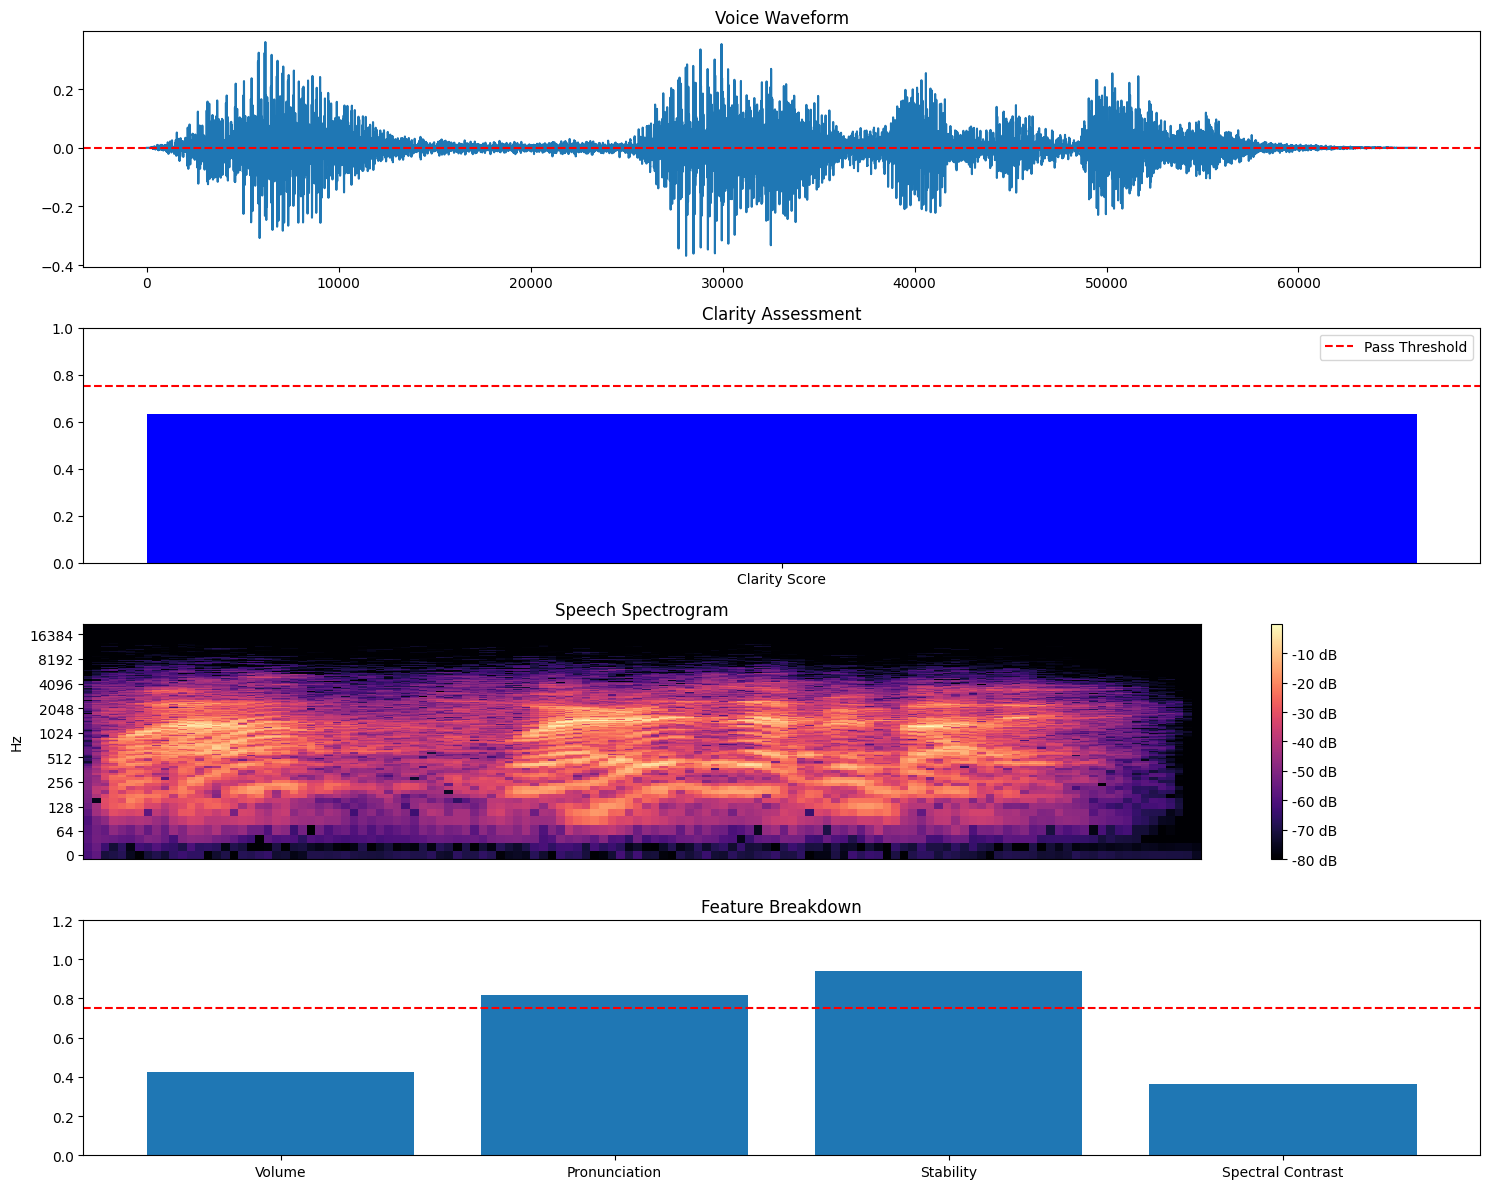


Processing: where-is-omni-man-where-is-he-immortal_69bpm.wav

Analysis Results for: where-is-omni-man-where-is-he-immortal_69bpm.wav

Status: FAIL
Clarity Score: 66.88%

Detailed Feedback:
FAIL: Voice clarity needs improvement
Issue: Voice volume is too low
Issue: Speech lacks clear distinction between sounds


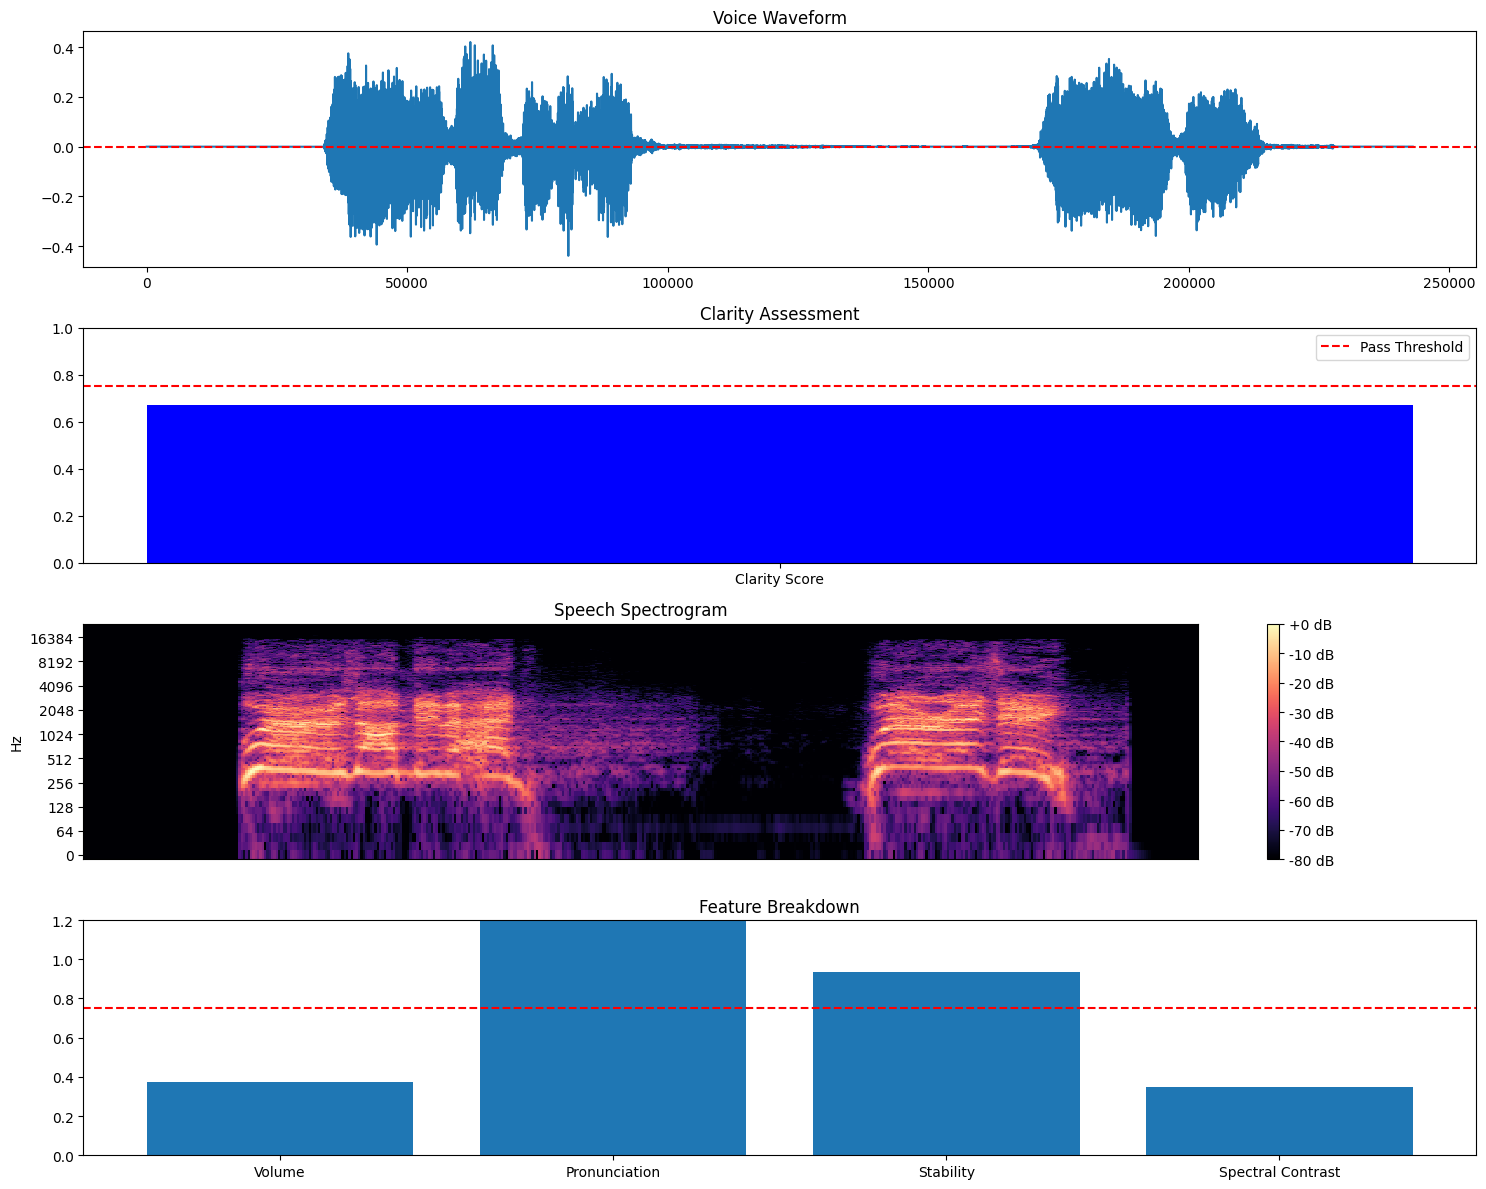

In [38]:
# Testing the Analyzer
def test_voice_analyzer():
    analyzer = VoiceAnalyzer()
    dataset_path = '/kaggle/input/voices'
    
    print("Voice Clarity Analysis System")
    print("=" * 50)
    print(f"Pass Threshold: {analyzer.CLARITY_THRESHOLD * 100}%")
    
    try:
        
        audio_files = [
            '/kaggle/input/voices/well-where-is-everybody_F_minor.wav',
            '/kaggle/input/voices/where-is-omni-man-where-is-he-immortal_69bpm.wav'
        ]
        
        print(f"\nFound {len(audio_files)} audio files")
        print("\nAnalyzing all files:")
        
        
        for file_path in audio_files:
            print(f"\nProcessing: {os.path.basename(file_path)}")
            analyzer.analyze_voice_file(file_path)
            
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        print("\nDebug information:")
        print(f"Working directory: {os.getcwd()}")


print("Starting voice clarity analysis...")
test_voice_analyzer()